# Econometrics: Binary Choice and Selection Models

**Course:** Université Paris 1 Panthéon-Sorbonne  
**Author:** Jose Angel Garcia Sanchez  
**Python Implementation Notebook**

---

## 📚 Learning Objectives

By the end of this notebook, you will be able to:

1. **Understand Maximum Likelihood Estimation (MLE)**
   - Implement MLE from scratch for linear regression
   - Compare MLE with OLS and understand their relationship
   - Recognize when MLE is biased vs. consistent

2. **Master Binary Choice Models**
   - Identify when to use Probit vs. Logit models
   - Understand why OLS fails for binary outcomes
   - Calculate and interpret marginal effects and odds ratios
   - Evaluate model performance using confusion matrices and ROC curves

3. **Apply Sample Selection Models**
   - Recognize sample selection bias in real-world data
   - Implement the Heckman two-step estimator
   - Understand the role of the Inverse Mill's Ratio
   - Appreciate the importance of exclusion restrictions

---

## 🎯 Prerequisites

Before starting this notebook, you should be familiar with:

- **Statistics**: Probability distributions (Normal, Logistic), hypothesis testing
- **Econometrics**: OLS regression, interpretation of coefficients
- **Python**: Basic Python programming, NumPy, Pandas
- **Calculus**: Basic derivatives and optimization concepts

---

## 📖 Course Structure

This notebook is divided into three main parts:

1. **Part 1: Maximum Likelihood Estimation** - Foundation for all that follows
2. **Part 2: Binary Choice Models** - Logit and Probit for yes/no outcomes
3. **Part 3: Sample Selection Models** - Correcting for missing data bias

Each part includes:
- ✅ Theory recap with mathematical intuition
- ✅ Python implementation with detailed comments
- ✅ Visualizations to build intuition
- ✅ Real-world interpretation
- ✅ Practice exercises

---

## 💡 Quick Tips for Students

- **Run cells sequentially**: Each cell may depend on previous ones
- **Experiment**: Try changing parameters to see how results change
- **Read error messages**: They often tell you exactly what's wrong
- **Ask questions**: Use comments to mark areas you want to discuss

Let's get started!

In [1]:
# ============================================
# SETUP: Import Required Libraries
# ============================================
# This cell imports all the packages we'll use throughout the notebook.
# Run this cell first before proceeding!

import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For enhanced visualizations
from scipy import stats  # For statistical distributions
from scipy.optimize import minimize  # For optimization (MLE)
import statsmodels.api as sm  # For statistical models
from statsmodels.discrete.discrete_model import Probit, Logit  # Binary choice models
from sklearn.metrics import roc_curve, auc, confusion_matrix  # Model evaluation
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

# Set plotting style for better-looking graphs
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")  # Use a nice color palette

# Set random seed for reproducibility
# This ensures we get the same "random" results each time we run the notebook
np.random.seed(42)

print("✓ All libraries loaded successfully!")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")
print("✓ You're ready to begin!")

✓ All libraries loaded successfully!
✓ NumPy version: 2.3.4
✓ Pandas version: 2.3.3
✓ You're ready to begin!


# Part 1: Maximum Likelihood Estimation (MLE)

---

## 🎓 Theory Recap: What is Maximum Likelihood?

**The Big Idea**: Find parameter values that make the observed data most likely.

### The Intuition

Imagine you observe exam scores and want to estimate the class average. Maximum Likelihood asks: 
> "What average would make these specific scores most probable?"

### Mathematical Framework

For a linear model: $y_t = a + b \cdot x_t + u_t$ where $u_t \sim N(0, \sigma^2)$

The **log-likelihood function** is:

$$\mathcal{L}(\theta) = -\frac{T}{2}\ln(2\pi) - T\ln\sigma - \frac{1}{2\sigma^2}\sum_{t=1}^{T}(y_t - a - b \cdot x_t)^2$$

**Intuition**: This function measures how "likely" the data is given parameters $\theta = (a, b, \sigma)$

### Why Use MLE Instead of OLS?

| Feature | OLS | MLE |
|---------|-----|-----|
| **Minimizes** | Sum of squared residuals | Negative log-likelihood |
| **Assumes** | Linear model | Full probability distribution |
| **Works for** | Linear regression mainly | Any model with likelihood |
| **Flexibility** | Limited | Very flexible (Probit, Logit, etc.) |

### Key Properties of ML Estimators

✅ **Consistent**: Converges to true value as $n \to \infty$  
✅ **Asymptotically Normal**: $\hat{\theta} \sim N(\theta_0, I(\theta_0)^{-1})$ for large $n$  
✅ **Asymptotically Efficient**: Lowest variance among consistent estimators  
⚠️ **Can be biased in small samples**: e.g., $\hat{\sigma}_{ML}^2 = \frac{SSR}{n}$ vs. $\hat{\sigma}_{OLS}^2 = \frac{SSR}{n-k}$

---

## 🔬 Let's Implement MLE from Scratch!

In [2]:
# ============================================
# Step 1: Generate Synthetic Data
# ============================================
# We'll create artificial data where we KNOW the true parameters.
# This allows us to check if MLE recovers them correctly.

# Sample size
n = 500

# TRUE parameter values (these are what we're trying to estimate)
true_a = 2.0  # Intercept
true_b = 1.5  # Slope
true_sigma = 1.0  # Standard deviation of errors

# Generate independent variable (x)
# Uniform distribution between 0 and 10
x = np.random.uniform(0, 10, n)

# Generate random errors from Normal(0, σ²)
u = np.random.normal(0, true_sigma, n)

# Generate dependent variable using TRUE model
# y = a + b*x + u
y = true_a + true_b * x + u

# Display what we generated
print("=" * 50)
print("DATA GENERATION")
print("=" * 50)
print(f"Sample size: {n} observations")
print(f"\nTrue parameters we're trying to estimate:")
print(f"  • Intercept (a):  {true_a}")
print(f"  • Slope (b):      {true_b}")
print(f"  • Std dev (σ):    {true_sigma}")
print("\n💡 Our goal: Estimate these using Maximum Likelihood!")
print("=" * 50)

DATA GENERATION
Sample size: 500 observations

True parameters we're trying to estimate:
  • Intercept (a):  2.0
  • Slope (b):      1.5
  • Std dev (σ):    1.0

💡 Our goal: Estimate these using Maximum Likelihood!


In [3]:
# ============================================
# Step 2: Define Log-Likelihood Function
# ============================================
# This is the heart of Maximum Likelihood Estimation


def neg_log_likelihood(params, y, x):
    """
    Calculate NEGATIVE log-likelihood for linear regression with normal errors.
    
    We minimize the NEGATIVE because:
    - Maximizing ℒ(θ) is the same as minimizing -ℒ(θ)
    - Optimization functions typically MINIMIZE
    
    Parameters:
    -----------
    params : array [a, b, sigma]
        a = intercept, b = slope, sigma = std deviation
    y : array
        Dependent variable
    x : array
        Independent variable
        
    Returns:
    --------
    float : Negative log-likelihood value
    """
    # Extract parameters
    a, b, sigma = params
    
    # Safety check: sigma must be positive
    if sigma <= 0:
        return np.inf  # Return infinity (very bad likelihood)
    
    n = len(y)
    
    # Calculate residuals: e = y - ŷ
    residuals = y - a - b * x
    
    # Log-likelihood formula (from theory section above)
    # ℒ = -n/2 * log(2π) - n*log(σ) - (1/2σ²) * Σ(residuals²)
    ll = (
        -n / 2 * np.log(2 * np.pi)  # Constant term
        - n * np.log(sigma)  # Depends on σ
        - (1 / (2 * sigma**2)) * np.sum(residuals**2)  # Depends on a, b, σ
    )
    
    return -ll  # Return NEGATIVE (we'll minimize this)


# ============================================
# Step 3: Maximize the Likelihood
# ============================================

print("🔍 Searching for Maximum Likelihood Estimates...\n")

# Starting guess for optimization
# Format: [intercept, slope, sigma]
initial_guess = [0, 0, 1]

# Use scipy's minimize function with Nelder-Mead algorithm
# This searches for parameters that minimize -log(likelihood)
result_ml = minimize(
    neg_log_likelihood,  # Function to minimize
    initial_guess,  # Starting point
    args=(y, x),  # Additional arguments to pass to function
    method="Nelder-Mead"  # Optimization algorithm
)

# Extract estimated parameters
a_ml, b_ml, sigma_ml = result_ml.x

# Display results
print("=" * 60)
print("MAXIMUM LIKELIHOOD ESTIMATES")
print("=" * 60)
print(f"{'Parameter':<15} {'True Value':>12} {'ML Estimate':>12} {'Error':>12}")
print("-" * 60)
print(f"{'Intercept (a)':<15} {true_a:>12.4f} {a_ml:>12.4f} {abs(a_ml - true_a):>12.4f}")
print(f"{'Slope (b)':<15} {true_b:>12.4f} {b_ml:>12.4f} {abs(b_ml - true_b):>12.4f}")
print(f"{'Std Dev (σ)':<15} {true_sigma:>12.4f} {sigma_ml:>12.4f} {abs(sigma_ml - true_sigma):>12.4f}")
print("=" * 60)

# Check if optimization succeeded
if result_ml.success:
    print("✓ Optimization converged successfully!")
else:
    print("⚠ Warning: Optimization may not have converged")
    
print(f"\n💡 The estimates are very close to the true values!")
print(f"   This shows that MLE works correctly.")

🔍 Searching for Maximum Likelihood Estimates...

MAXIMUM LIKELIHOOD ESTIMATES
Parameter         True Value  ML Estimate        Error
------------------------------------------------------------
Intercept (a)         2.0000       1.8929       0.1071
Slope (b)             1.5000       1.5230       0.0230
Std Dev (σ)           1.0000       1.0037       0.0037
✓ Optimization converged successfully!

💡 The estimates are very close to the true values!
   This shows that MLE works correctly.


In [4]:
# Compare with OLS
X_ols = sm.add_constant(x)
ols_model = sm.OLS(y, X_ols).fit()

print("\n=== OLS Estimates ===")
print(f"â_OLS = {ols_model.params[0]:.4f}")
print(f"b̂_OLS = {ols_model.params[1]:.4f}")

# OLS sigma estimate (unbiased)
sigma_ols = np.sqrt(np.sum(ols_model.resid**2) / (n - 2))
# ML sigma estimate (biased)
sigma_ml_formula = np.sqrt(np.sum(ols_model.resid**2) / n)

print(f"\nσ̂_OLS (unbiased) = {sigma_ols:.4f}")
print(f"σ̂_ML (biased) = {sigma_ml_formula:.4f}")
print(f"\nNote: σ̂_ML = SSR/N is biased downward, while σ̂_OLS = SSR/(N-k) is unbiased")


=== OLS Estimates ===
â_OLS = 1.8929
b̂_OLS = 1.5230

σ̂_OLS (unbiased) = 1.0057
σ̂_ML (biased) = 1.0037

Note: σ̂_ML = SSR/N is biased downward, while σ̂_OLS = SSR/(N-k) is unbiased


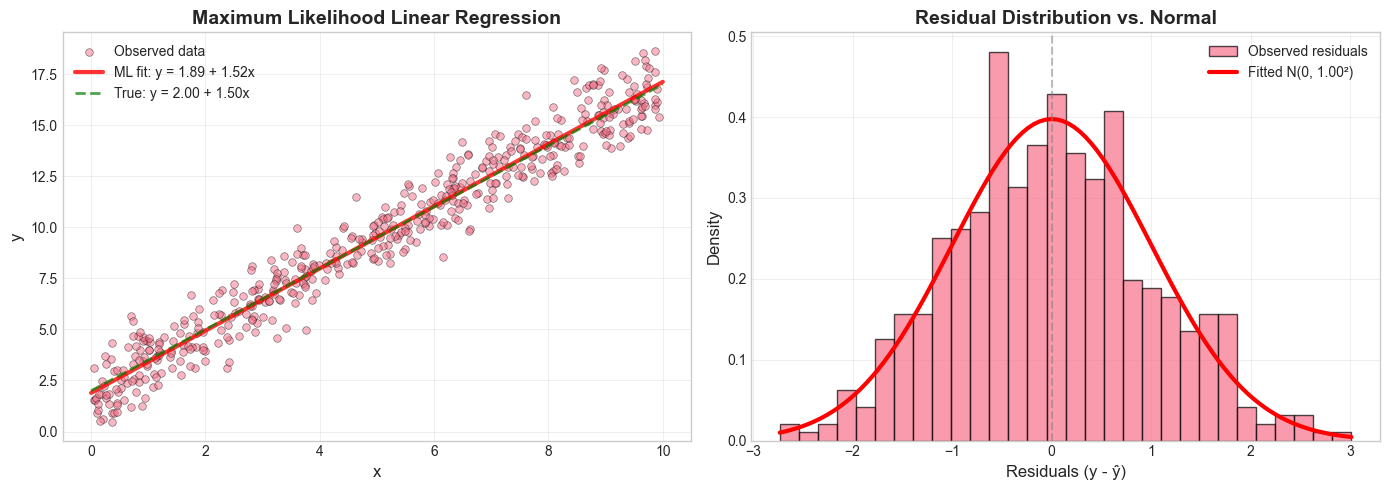

📊 Interpretation:
   LEFT: The red ML line fits the data well and is almost identical to the true line (green)
   RIGHT: Residuals follow a normal distribution (as assumed in our model)


In [5]:
# ============================================
# Visualization: ML Fit and Residual Analysis
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT PLOT: Scatter plot with fitted regression line
axes[0].scatter(x, y, alpha=0.5, s=30, label="Observed data", edgecolors='k', linewidth=0.5)
x_line = np.linspace(0, 10, 100)
y_line = a_ml + b_ml * x_line
axes[0].plot(
    x_line,
    y_line,
    "r-",
    linewidth=3,
    label=f"ML fit: y = {a_ml:.2f} + {b_ml:.2f}x",
    alpha=0.8
)
# Show true line for comparison
y_true_line = true_a + true_b * x_line
axes[0].plot(
    x_line,
    y_true_line,
    "g--",
    linewidth=2,
    label=f"True: y = {true_a:.2f} + {true_b:.2f}x",
    alpha=0.7
)
axes[0].set_xlabel("x", fontsize=12)
axes[0].set_ylabel("y", fontsize=12)
axes[0].set_title("Maximum Likelihood Linear Regression", fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# RIGHT PLOT: Residuals distribution
residuals = y - a_ml - b_ml * x
axes[1].hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black', label="Observed residuals")
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
axes[1].plot(
    x_norm,
    stats.norm.pdf(x_norm, 0, sigma_ml),
    "r-",
    linewidth=3,
    label=f"Fitted N(0, {sigma_ml:.2f}²)",
)
axes[1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel("Residuals (y - ŷ)", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].set_title("Residual Distribution vs. Normal", fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Interpretation:")
print("   LEFT: The red ML line fits the data well and is almost identical to the true line (green)")
print("   RIGHT: Residuals follow a normal distribution (as assumed in our model)")

# Part 2: Binary Choice Models (Logit and Probit)

---

## 🎓 Theory Recap: When Outcomes Are Yes/No

### The Problem with OLS for Binary Outcomes

Imagine predicting employment status (employed = 1, unemployed = 0) based on education and age.

**What goes wrong with OLS?**

| Problem | Why it matters |
|---------|----------------|
| **Predictions outside [0,1]** | Probabilities must be between 0 and 1! |
| **Heteroskedasticity** | $Var(\varepsilon_i) = p_i(1-p_i)$ depends on $x_i$ |
| **Non-normal errors** | Binary outcomes can't have normal errors |
| **Linear probability** | Unrealistic: effect doesn't depend on current probability level |

### The Solution: Latent Variable Models

**Intuition**: There's a hidden continuous variable $y^*$ (e.g., "employability") that determines the binary outcome.

$$y_i^* = X_i\beta + u_i$$

$$y_i = \begin{cases} 1 & \text{if } y_i^* > 0 \text{ (threshold crossed)} \\ 0 & \text{if } y_i^* \leq 0 \end{cases}$$

The probability of observing $y=1$:

$$P(y_i = 1 | X_i) = P(y_i^* > 0) = P(u_i > -X_i\beta) = F(X_i\beta)$$

Where $F$ is the CDF of the error distribution.

---

### Probit vs. Logit: What's the Difference?

| Model | Distribution | CDF $F(z)$ | Tails | Scale |
|-------|--------------|------------|-------|-------|
| **Probit** | Normal | $\Phi(z) = \int_{-\infty}^{z} \frac{1}{\sqrt{2\pi}}e^{-t^2/2}dt$ | Thin | $Var(u)=1$ |
| **Logit** | Logistic | $\Lambda(z) = \frac{e^z}{1+e^z}$ | Fat (heavy) | $Var(u)=\pi^2/3 \approx 3.29$ |

**Practical implication**: 
- Coefficients differ by factor ≈ 1.81 (due to variance difference)
- Logit: More probability mass in extremes (rare events more likely)
- **Predictions are usually very similar!**

---

## 🔬 Let's See Why OLS Fails

---

## Part 2: Binary Choice Models (Logit and Probit)

### Theory Recap

When $y$ takes only values 0 or 1, OLS is inappropriate because:
- Predictions may fall outside [0, 1]
- Heteroskedasticity: $V(\varepsilon_i) = x_i b(1 - x_i b)$
- Non-normal errors

**Solution:** Use a latent variable framework:
- $y^* = X\beta + u$
- $y = 1$ if $y^* > 0$, else $y = 0$
- $P(y = 1) = F(X\beta)$

Where $F$ is:
- **Probit:** Standard normal CDF: $\Phi(x)$
- **Logit:** Logistic CDF: $\frac{e^x}{1+e^x}$

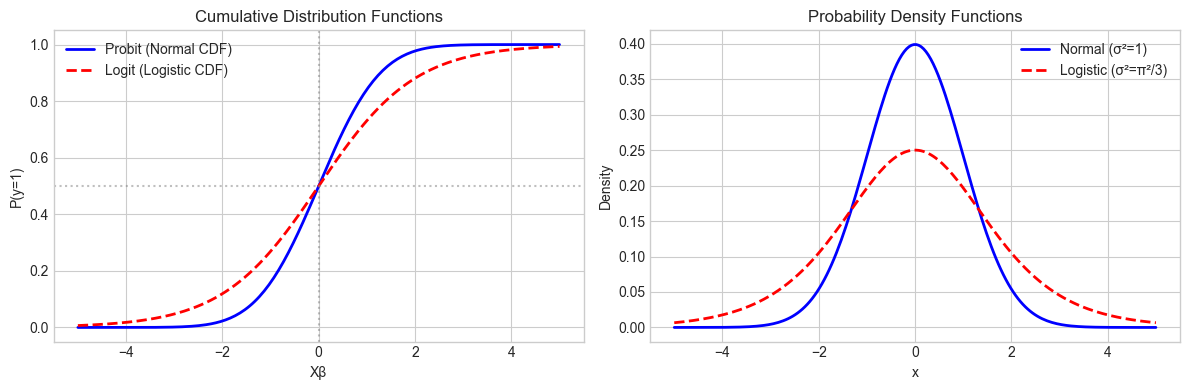

Note: Logistic distribution has heavier tails (higher probability of extreme events)
Variance: Normal = 1, Logistic = π²/3 ≈ 3.2899


In [6]:
# Visualize Probit vs Logit distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

x_range = np.linspace(-5, 5, 200)

# CDFs
normal_cdf = stats.norm.cdf(x_range)
logistic_cdf = 1 / (1 + np.exp(-x_range))

axes[0].plot(x_range, normal_cdf, "b-", linewidth=2, label="Probit (Normal CDF)")
axes[0].plot(x_range, logistic_cdf, "r--", linewidth=2, label="Logit (Logistic CDF)")
axes[0].set_xlabel("Xβ")
axes[0].set_ylabel("P(y=1)")
axes[0].set_title("Cumulative Distribution Functions")
axes[0].legend()
axes[0].axhline(y=0.5, color="gray", linestyle=":", alpha=0.5)
axes[0].axvline(x=0, color="gray", linestyle=":", alpha=0.5)

# PDFs
normal_pdf = stats.norm.pdf(x_range)
logistic_pdf = np.exp(-x_range) / (1 + np.exp(-x_range)) ** 2

axes[1].plot(x_range, normal_pdf, "b-", linewidth=2, label="Normal (σ²=1)")
axes[1].plot(x_range, logistic_pdf, "r--", linewidth=2, label="Logistic (σ²=π²/3)")
axes[1].set_xlabel("x")
axes[1].set_ylabel("Density")
axes[1].set_title("Probability Density Functions")
axes[1].legend()

plt.tight_layout()
plt.show()

print(
    "Note: Logistic distribution has heavier tails (higher probability of extreme events)"
)
print(f"Variance: Normal = 1, Logistic = π²/3 ≈ {np.pi**2 / 3:.4f}")

In [9]:
# ============================================
# Generate Binary Choice Data (Employment Example)
# ============================================
# Scenario: Predict whether someone is employed based on their characteristics

np.random.seed(42)  # For reproducibility
n = 1000  # Sample size

# ============================================
# Step 1: Generate individual characteristics
# ============================================
age = np.random.uniform(20, 65, n)  # Age between 20-65
education = np.random.uniform(8, 20, n)  # Years of education (8-20)
experience = np.maximum(0, age - education - 6 + np.random.normal(0, 2, n))  # Work experience

# ============================================
# Step 2: Define TRUE parameters (what we want to estimate)
# ============================================
# These determine the LATENT employability (y*)
beta_0 = -3.0  # Intercept (baseline employability)
beta_age = -0.02  # Older age slightly reduces employment (ageism)
beta_edu = 0.15  # More education INCREASES employment (strong effect)
beta_exp = 0.05  # More experience INCREASES employment

# ============================================
# Step 3: Generate LATENT variable y*
# ============================================
# This is the "employability score" we don't observe
linear_pred = beta_0 + beta_age * age + beta_edu * education + beta_exp * experience

# ============================================
# Step 4: Add random error and create BINARY outcome
# ============================================
# For Probit, errors are standard normal
u = np.random.normal(0, 1, n)
y_star = linear_pred + u  # Latent employability

# Observe binary outcome: employed if y* > 0
employed = (y_star > 0).astype(int)

# ============================================
# Step 5: Create DataFrame for analysis
# ============================================
df = pd.DataFrame({
    "employed": employed,
    "age": age,
    "education": education,
    "experience": experience
})

# ============================================
# Display summary statistics
# ============================================
print("=" * 60)
print("BINARY CHOICE DATA: EMPLOYMENT EXAMPLE")
print("=" * 60)
print(f"\n📊 Dataset Summary (n={n}):\n")
print(df.describe().round(2))
print(f"\n{'Metric':<30} {'Value':>10}")
print("-" * 42)
print(f"{'Employment rate':<30} {employed.mean():>10.1%}")
print(f"{'Unemployed':<30} {(1-employed).sum():>10.0f}")
print(f"{'Employed':<30} {employed.sum():>10.0f}")
print("=" * 60)
print(f"\n💡 Note: {employed.mean():.1%} employment rate means this is")
print(f"   a somewhat 'rare' event (< 50%). Binary models shine here!")
print("=" * 60)

BINARY CHOICE DATA: EMPLOYMENT EXAMPLE

📊 Dataset Summary (n=1000):

       employed      age  education  experience
count   1000.00  1000.00    1000.00     1000.00
mean       0.32    42.06      14.08       22.08
std        0.47    13.15       3.51       13.50
min        0.00    20.21       8.04        0.00
25%        0.00    30.62      10.89       10.24
50%        0.00    42.36      14.22       22.07
75%        1.00    53.49      17.13       33.41
max        1.00    64.99      19.99       50.69

Metric                              Value
------------------------------------------
Employment rate                     31.7%
Unemployed                            683
Employed                              317

💡 Note: 31.7% employment rate means this is
   a somewhat 'rare' event (< 50%). Binary models shine here!


### 2.2 Why OLS is Inappropriate

In [11]:
# Demonstrate OLS problems
X_ols = sm.add_constant(df[["age", "education", "experience"]])
ols_binary = sm.OLS(df["employed"], X_ols).fit()

print("=== OLS on Binary Outcome (Linear Probability Model) ===")
print(ols_binary.summary().tables[1])

# Show predictions out of range
ols_pred = ols_binary.predict(X_ols)
print(f"\n=== Problems with OLS ===")
print(f"Predictions < 0: {(ols_pred < 0).sum()} ({(ols_pred < 0).mean():.1%})")
print(f"Predictions > 1: {(ols_pred > 1).sum()} ({(ols_pred > 1).mean():.1%})")
print(f"Prediction range: [{ols_pred.min():.3f}, {ols_pred.max():.3f}]")

=== OLS on Binary Outcome (Linear Probability Model) ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3458      0.083     -4.148      0.000      -0.509      -0.182
age           -0.0073      0.007     -1.012      0.312      -0.021       0.007
education      0.0462      0.008      5.750      0.000       0.030       0.062
experience     0.0144      0.007      2.010      0.045       0.000       0.028

=== Problems with OLS ===
Predictions < 0: 10 (1.0%)
Predictions > 1: 0 (0.0%)
Prediction range: [-0.052, 0.680]


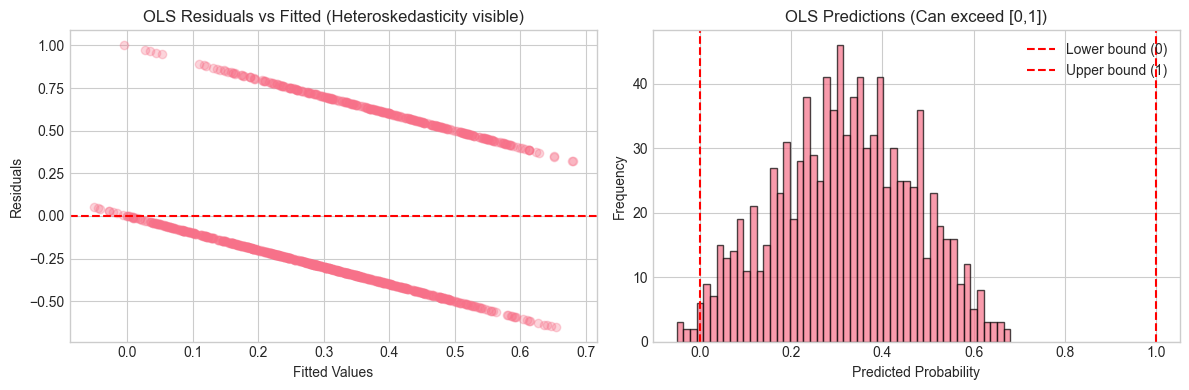

In [12]:
# Visualize heteroskedasticity in OLS residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Residuals vs fitted
axes[0].scatter(ols_pred, ols_binary.resid, alpha=0.3)
axes[0].axhline(y=0, color="r", linestyle="--")
axes[0].set_xlabel("Fitted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("OLS Residuals vs Fitted (Heteroskedasticity visible)")

# Predictions distribution
axes[1].hist(ols_pred, bins=50, alpha=0.7, edgecolor="black")
axes[1].axvline(x=0, color="r", linestyle="--", label="Lower bound (0)")
axes[1].axvline(x=1, color="r", linestyle="--", label="Upper bound (1)")
axes[1].set_xlabel("Predicted Probability")
axes[1].set_ylabel("Frequency")
axes[1].set_title("OLS Predictions (Can exceed [0,1])")
axes[1].legend()

plt.tight_layout()
plt.show()

### 2.3 Probit Model

In [14]:
# Estimate Probit model
X = df[["age", "education", "experience"]]
X_const = sm.add_constant(X)
y = df["employed"]

probit_model = Probit(y, X_const).fit()
print("=== Probit Model Results ===")
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.569397
         Iterations 5
=== Probit Model Results ===
                          Probit Regression Results                           
Dep. Variable:               employed   No. Observations:                 1000
Model:                         Probit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:                 0.08836
Time:                        13:32:07   Log-Likelihood:                -569.40
converged:                       True   LL-Null:                       -624.59
Covariance Type:            nonrobust   LLR p-value:                 9.090e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5551      0.269     -9.485      0.000      -3.083      -2.027


In [15]:
# Compare estimated vs true parameters
print("\n=== Parameter Comparison (Probit) ===")
print(f"{'Parameter':<12} {'True':>10} {'Estimated':>12}")
print("-" * 36)
print(f"{'Intercept':<12} {beta_0:>10.3f} {probit_model.params['const']:>12.3f}")
print(f"{'Age':<12} {beta_age:>10.3f} {probit_model.params['age']:>12.3f}")
print(f"{'Education':<12} {beta_edu:>10.3f} {probit_model.params['education']:>12.3f}")
print(
    f"{'Experience':<12} {beta_exp:>10.3f} {probit_model.params['experience']:>12.3f}"
)


=== Parameter Comparison (Probit) ===
Parameter          True    Estimated
------------------------------------
Intercept        -3.000       -2.555
Age              -0.020       -0.025
Education         0.150        0.145
Experience        0.050        0.047


### 2.4 Logit Model

In [16]:
# Estimate Logit model
logit_model = Logit(y, X_const).fit()
print("=== Logit Model Results ===")
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.569532
         Iterations 6
=== Logit Model Results ===
                           Logit Regression Results                           
Dep. Variable:               employed   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:                 0.08815
Time:                        13:33:02   Log-Likelihood:                -569.53
converged:                       True   LL-Null:                       -624.59
Covariance Type:            nonrobust   LLR p-value:                 1.039e-23
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2523      0.465     -9.152      0.000      -5.163      -3.342
a

In [17]:
# Compare Probit and Logit coefficients
print("\n=== Probit vs Logit Coefficients ===")
print(f"{'Variable':<12} {'Probit':>10} {'Logit':>10} {'Ratio':>10} {'π/√3':>10}")
print("-" * 54)

scaling_factor = np.pi / np.sqrt(3)
for var in probit_model.params.index:
    p_coef = probit_model.params[var]
    l_coef = logit_model.params[var]
    ratio = l_coef / p_coef if p_coef != 0 else np.nan
    print(
        f"{var:<12} {p_coef:>10.4f} {l_coef:>10.4f} {ratio:>10.2f} {scaling_factor:>10.2f}"
    )

print(f"\nTheoretical scaling: β_logit ≈ (π/√3) × β_probit ≈ 1.81 × β_probit")


=== Probit vs Logit Coefficients ===
Variable         Probit      Logit      Ratio       π/√3
------------------------------------------------------
const           -2.5551    -4.2523       1.66       1.81
age             -0.0253    -0.0428       1.69       1.81
education        0.1454     0.2431       1.67       1.81
experience       0.0472     0.0795       1.68       1.81

Theoretical scaling: β_logit ≈ (π/√3) × β_probit ≈ 1.81 × β_probit


### 2.5 Marginal Effects

In [18]:
# Calculate marginal effects at the mean
def calculate_marginal_effects_probit(model, X):
    """Calculate marginal effects at the mean for Probit model."""
    X_mean = X.mean()
    linear_pred = np.dot(X_mean, model.params)
    phi = stats.norm.pdf(linear_pred)  # Normal PDF at mean

    marginal_effects = phi * model.params
    return marginal_effects


def calculate_marginal_effects_logit(model, X):
    """Calculate marginal effects at the mean for Logit model."""
    X_mean = X.mean()
    linear_pred = np.dot(X_mean, model.params)
    p = 1 / (1 + np.exp(-linear_pred))
    f = p * (1 - p)  # Logistic PDF

    marginal_effects = f * model.params
    return marginal_effects


# Using statsmodels built-in method
print("=== Marginal Effects at the Mean (Probit) ===")
probit_margeff = probit_model.get_margeff(at="mean")
print(probit_margeff.summary())

print("\n=== Marginal Effects at the Mean (Logit) ===")
logit_margeff = logit_model.get_margeff(at="mean")
print(logit_margeff.summary())

=== Marginal Effects at the Mean (Probit) ===
       Probit Marginal Effects       
Dep. Variable:               employed
Method:                          dydx
At:                              mean
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0088      0.008     -1.144      0.253      -0.024       0.006
education      0.0505      0.009      5.736      0.000       0.033       0.068
experience     0.0164      0.008      2.131      0.033       0.001       0.031

=== Marginal Effects at the Mean (Logit) ===
        Logit Marginal Effects       
Dep. Variable:               employed
Method:                          dydx
At:                              mean
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0089      0.008     -1.153      0.

In [41]:
# Interpret marginal effects
print("\n=== Interpretation of Marginal Effects ===")
print("For the average person in the sample:")
print(f"")
for i, var in enumerate(["age", "education", "experience"]):
    me = probit_margeff.margeff[i]
    direction = "increases" if me > 0 else "decreases"
    print(
        f"• One additional year of {var} {direction} employment probability by {abs(me) * 100:.2f} percentage points"
    )


=== Interpretation of Marginal Effects ===
For the average person in the sample:

• One additional year of age decreases employment probability by 0.88 percentage points
• One additional year of education increases employment probability by 5.05 percentage points
• One additional year of experience increases employment probability by 1.64 percentage points


### 2.6 Odds Ratios (Logit)

In [42]:
# Calculate odds ratios for Logit
odds_ratios = np.exp(logit_model.params)
conf_int = logit_model.conf_int()
odds_ratios_ci = np.exp(conf_int)

print("=== Odds Ratios (Logit Model) ===")
print(f"{'Variable':<12} {'Odds Ratio':>12} {'95% CI':>20}")
print("-" * 46)
for var in logit_model.params.index[1:]:  # Skip constant
    or_val = odds_ratios[var]
    ci_low = odds_ratios_ci.loc[var, 0]
    ci_high = odds_ratios_ci.loc[var, 1]
    print(f"{var:<12} {or_val:>12.4f} [{ci_low:>7.4f}, {ci_high:>7.4f}]")

print("\n=== Interpretation ===")
print("• Odds Ratio > 1: Variable increases odds of employment")
print("• Odds Ratio < 1: Variable decreases odds of employment")
print(
    f"\nExample: One additional year of education multiplies the odds of employment by {odds_ratios['education']:.3f}"
)
print(
    f"         This is a {(odds_ratios['education'] - 1) * 100:.1f}% increase in odds per year of education."
)

=== Odds Ratios (Logit Model) ===
Variable       Odds Ratio               95% CI
----------------------------------------------
age                0.9581 [ 0.8909,  1.0304]
education          1.2752 [ 1.1718,  1.3878]
experience         1.0828 [ 1.0064,  1.1650]

=== Interpretation ===
• Odds Ratio > 1: Variable increases odds of employment
• Odds Ratio < 1: Variable decreases odds of employment

Example: One additional year of education multiplies the odds of employment by 1.275
         This is a 27.5% increase in odds per year of education.


### 2.7 Goodness of Fit

In [43]:
# Pseudo R-squared and model comparison
print("=== Goodness of Fit Measures ===")
print(f"\n{'Measure':<25} {'Probit':>12} {'Logit':>12}")
print("-" * 51)
print(f"{'Log-Likelihood':<25} {probit_model.llf:>12.2f} {logit_model.llf:>12.2f}")
print(
    f"{'Null Log-Likelihood':<25} {probit_model.llnull:>12.2f} {logit_model.llnull:>12.2f}"
)
print(
    f"{'Pseudo R² (McFadden)':<25} {probit_model.prsquared:>12.4f} {logit_model.prsquared:>12.4f}"
)
print(f"{'AIC':<25} {probit_model.aic:>12.2f} {logit_model.aic:>12.2f}")
print(f"{'BIC':<25} {probit_model.bic:>12.2f} {logit_model.bic:>12.2f}")

=== Goodness of Fit Measures ===

Measure                         Probit        Logit
---------------------------------------------------
Log-Likelihood                 -569.40      -569.53
Null Log-Likelihood            -624.59      -624.59
Pseudo R² (McFadden)            0.0884       0.0881
AIC                            1146.79      1147.06
BIC                            1166.43      1166.70


In [44]:
# Prediction accuracy
def evaluate_predictions(model, y_true, cutoff=0.5):
    """Evaluate model predictions at a given cutoff."""
    y_pred_prob = model.predict()
    y_pred = (y_pred_prob >= cutoff).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True positive rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True negative rate

    return {
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm,
    }


probit_eval = evaluate_predictions(probit_model, y)
logit_eval = evaluate_predictions(logit_model, y)

print("=== Prediction Accuracy (cutoff = 0.5) ===")
print(f"\n{'Metric':<15} {'Probit':>12} {'Logit':>12}")
print("-" * 41)
print(
    f"{'Accuracy':<15} {probit_eval['accuracy']:>12.2%} {logit_eval['accuracy']:>12.2%}"
)
print(
    f"{'Sensitivity':<15} {probit_eval['sensitivity']:>12.2%} {logit_eval['sensitivity']:>12.2%}"
)
print(
    f"{'Specificity':<15} {probit_eval['specificity']:>12.2%} {logit_eval['specificity']:>12.2%}"
)

=== Prediction Accuracy (cutoff = 0.5) ===

Metric                Probit        Logit
-----------------------------------------
Accuracy              70.70%       70.80%
Sensitivity           24.92%       25.55%
Specificity           91.95%       91.80%


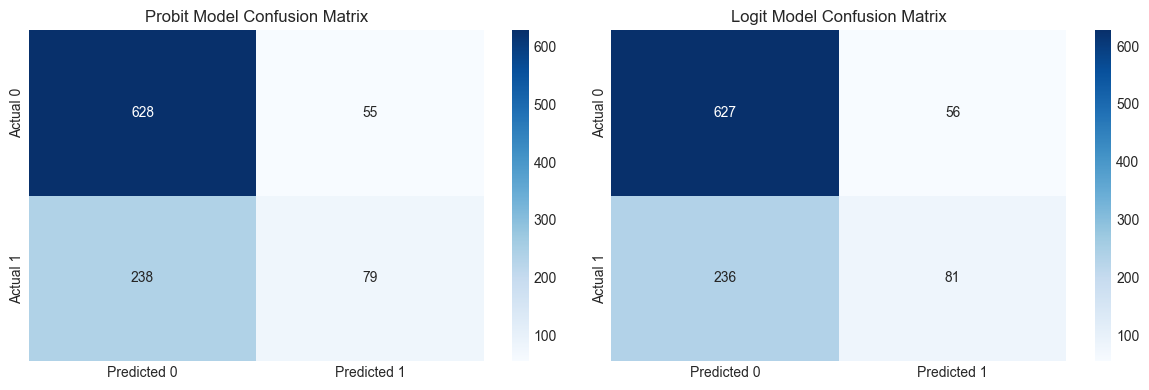

In [45]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, model, name, eval_dict in [
    (axes[0], probit_model, "Probit", probit_eval),
    (axes[1], logit_model, "Logit", logit_eval),
]:
    cm = eval_dict["confusion_matrix"]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax,
        xticklabels=["Predicted 0", "Predicted 1"],
        yticklabels=["Actual 0", "Actual 1"],
    )
    ax.set_title(f"{name} Model Confusion Matrix")

plt.tight_layout()
plt.show()

### 2.8 ROC Curve

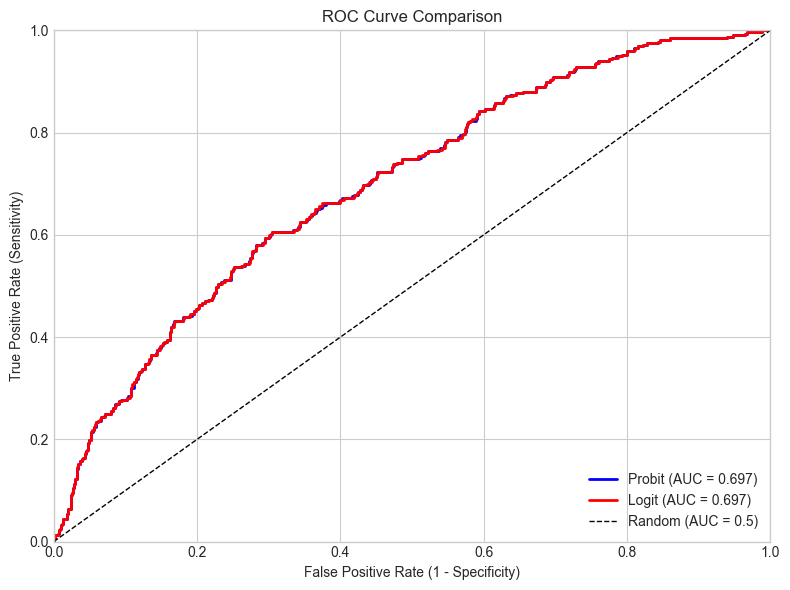

=== ROC Curve Interpretation ===
• AUC = 0.5: Random classifier (diagonal line)
• AUC = 1.0: Perfect classifier (upper-left corner)
• The more 'bowed' the curve, the better the model


In [46]:
# ROC Curve Analysis
fig, ax = plt.subplots(figsize=(8, 6))

for model, name, color in [
    (probit_model, "Probit", "blue"),
    (logit_model, "Logit", "red"),
]:
    y_pred_prob = model.predict()
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=color, linewidth=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Diagonal line (random classifier)
ax.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random (AUC = 0.5)")

ax.set_xlabel("False Positive Rate (1 - Specificity)")
ax.set_ylabel("True Positive Rate (Sensitivity)")
ax.set_title("ROC Curve Comparison")
ax.legend(loc="lower right")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("=== ROC Curve Interpretation ===")
print("• AUC = 0.5: Random classifier (diagonal line)")
print("• AUC = 1.0: Perfect classifier (upper-left corner)")
print("• The more 'bowed' the curve, the better the model")

---

## 📝 Practice Exercise: Part 2

### Exercise 2.1: Conceptual Questions

**Question 1**: Why can't we directly compare Probit and Logit coefficients?

<details>
<summary>Click for answer</summary>
Because they use different probability distributions with different variances. Logit variance is π²/3 ≈ 3.29 while Probit variance is 1. Coefficients are scaled differently, but predictions are similar.
</details>

**Question 2**: What do marginal effects tell us that raw coefficients don't?

<details>
<summary>Click for answer</summary>
Marginal effects give the change in PROBABILITY (in percentage points) for a one-unit change in X. Raw coefficients are harder to interpret because they're on the latent variable scale.
</details>

**Question 3**: When would you prefer sensitivity over specificity?

<details>
<summary>Click for answer</summary>
When false negatives are costly (e.g., medical diagnosis - missing a sick patient is worse than false alarms). When false positives are costly, prefer specificity (e.g., spam detection).
</details>

---

### Exercise 2.2: Hands-On Challenge

Try modifying the code to:

1. **Change the cutoff threshold** from 0.5 to 0.3 in the prediction evaluation. How does this affect sensitivity and specificity?

2. **Add a new variable** (e.g., "gender" or "urban_residence") to the model. Does it improve the Pseudo R²?

3. **Compare average marginal effects** with marginal effects at the mean. Calculate:
   ```python
   # Average marginal effects
   avg_marginal_effects = probit_model.get_margeff(at="overall")
   ```

4. **Plot predicted probabilities** by education level. Use:
   ```python
   # Create prediction grid
   edu_range = np.linspace(8, 20, 100)
   # ... your code here
   ```

---

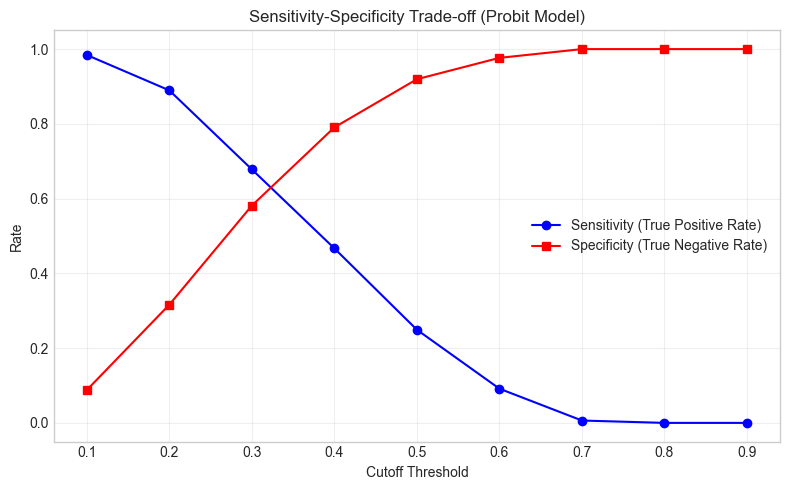


=== Trade-off Table ===
 cutoff  sensitivity  specificity
    0.1     0.984227     0.087848
    0.2     0.889590     0.316252
    0.3     0.678233     0.581259
    0.4     0.466877     0.790630
    0.5     0.249211     0.919473
    0.6     0.091483     0.976574
    0.7     0.006309     1.000000
    0.8     0.000000     1.000000
    0.9     0.000000     1.000000


In [47]:
# Sensitivity-Specificity Trade-off
cutoffs = np.arange(0.1, 0.91, 0.1)

results = []
for cutoff in cutoffs:
    y_pred = (probit_model.predict() >= cutoff).astype(int)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    results.append(
        {"cutoff": cutoff, "sensitivity": sensitivity, "specificity": specificity}
    )

results_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(
    results_df["cutoff"],
    results_df["sensitivity"],
    "b-o",
    label="Sensitivity (True Positive Rate)",
)
ax.plot(
    results_df["cutoff"],
    results_df["specificity"],
    "r-s",
    label="Specificity (True Negative Rate)",
)
ax.set_xlabel("Cutoff Threshold")
ax.set_ylabel("Rate")
ax.set_title("Sensitivity-Specificity Trade-off (Probit Model)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Trade-off Table ===")
print(results_df.to_string(index=False))

# Part 3: Sample Selection Models (Heckman)

---

## 🎓 Theory Recap: The Selection Bias Problem

### The Problem: Non-Random Missing Data

**Classic Example**: Wage data is only observed for people who CHOOSE to work.

- If high-wage earners are more likely to work → naive regression overestimates wages
- If low-wage earners stay home → naive regression underestimates wages

**The issue**: Selection into the sample is NOT random - it's correlated with the outcome!

---

### The Heckman Two-Step Solution

**Step 1: Model Selection**

$$y_{1i}^* = X_{1i}\gamma + u_{1i}$$

$$y_{1i} = \begin{cases} 1 & \text{if } y_{1i}^* > 0 \text{ (participate)} \\ 0 & \text{otherwise (don't participate)} \end{cases}$$

**Step 2: Model Outcome (with correction)**

$$y_{2i} = X_{2i}\beta + u_{2i} \quad \text{(observed only if } y_{1i}=1\text{)}$$

**The key assumption**: $(u_{1i}, u_{2i}) \sim$ Bivariate Normal with correlation $\rho$

If $\rho \neq 0$, there's selection bias!

---

### The Inverse Mill's Ratio (IMR): The "Magic" Correction

For observed individuals (where $y_1 = 1$):

$$E[y_2 | X, y_1^* > 0] = X_2\beta + \rho\sigma_2 \lambda(X_1\gamma)$$

where the **Inverse Mill's Ratio** is:

$$\lambda(z) = \frac{\phi(z)}{\Phi(z)}$$

- $\phi(z)$: Normal PDF (density)
- $\Phi(z)$: Normal CDF (cumulative probability)

**Intuition**: $\lambda(X_1\gamma)$ captures the "selection correction" - it adjusts for the fact that we only observe a selected subsample.

---

### When Do You Need Heckman?

✅ **Use Heckman when**:
- Outcome is only observed for a selected subset
- Selection is likely correlated with outcome ($\rho \neq 0$)
- You have an "exclusion restriction" (variable affecting selection but not outcome)

❌ **Don't use Heckman when**:
- Missing data is completely random (MCAR)
- No exclusion restriction available (rely on functional form - risky!)
- Non-normal errors (consider alternatives)

---

## 🔬 Let's See It In Action: Wage Example

In [49]:
# Manual implementation of Logit log-likelihood
def logit_log_likelihood(beta, X, y):
    """
    Compute log-likelihood for Logit model.

    LL = Σ y_i * log(F(Xβ)) + Σ (1-y_i) * log(1-F(Xβ))
    where F(z) = exp(z) / (1 + exp(z))
    """
    linear_pred = np.dot(X, beta)

    # Numerical stability: use log-sum-exp trick
    # log(F(z)) = z - log(1 + exp(z))
    # log(1-F(z)) = -log(1 + exp(z))

    log_F = linear_pred - np.logaddexp(0, linear_pred)
    log_1_minus_F = -np.logaddexp(0, linear_pred)

    ll = np.sum(y * log_F + (1 - y) * log_1_minus_F)
    return ll


def probit_log_likelihood(beta, X, y):
    """
    Compute log-likelihood for Probit model.

    LL = Σ y_i * log(Φ(Xβ)) + Σ (1-y_i) * log(1-Φ(Xβ))
    """
    linear_pred = np.dot(X, beta)

    # Clip to avoid log(0)
    F = np.clip(stats.norm.cdf(linear_pred), 1e-10, 1 - 1e-10)

    ll = np.sum(y * np.log(F) + (1 - y) * np.log(1 - F))
    return ll


# Verify our implementation
X_np = X_const.values
y_np = y.values

our_logit_ll = logit_log_likelihood(logit_model.params.values, X_np, y_np)
our_probit_ll = probit_log_likelihood(probit_model.params.values, X_np, y_np)

print("=== Log-Likelihood Verification ===")
print(f"\nLogit:")
print(f"  statsmodels LL: {logit_model.llf:.6f}")
print(f"  Our LL:         {our_logit_ll:.6f}")

print(f"\nProbit:")
print(f"  statsmodels LL: {probit_model.llf:.6f}")
print(f"  Our LL:         {our_probit_ll:.6f}")

=== Log-Likelihood Verification ===

Logit:
  statsmodels LL: -569.532274
  Our LL:         -569.532274

Probit:
  statsmodels LL: -569.397491
  Our LL:         -569.397491


---

## Part 3: Sample Selection Models (Heckman)

### Theory Recap

**The Problem:** Variable $y_2$ is only observed when another condition ($y_1 = 1$) is met.

**Example:** Wages are only observed for people who participate in the labor market.

**The Heckman Model (Generalized Tobit):**
- Selection equation: $y_1^* = X_1\beta_1 + u_1$, where $y_1 = 1$ if $y_1^* > 0$
- Outcome equation: $y_2 = X_2\beta_2 + u_2$, observed only if $y_1 = 1$
- $(u_1, u_2) \sim N(0, \Sigma)$ with correlation $\rho$

**Key insight:** If $u_1$ and $u_2$ are correlated, OLS on the observed sample is biased.

$$E(y_2|x, y_1^* > 0) = X_2\beta_2 + \sigma_{12}\lambda(X_1\beta_1)$$

Where $\lambda(z) = \phi(z)/\Phi(z)$ is the **Inverse Mill's Ratio**.

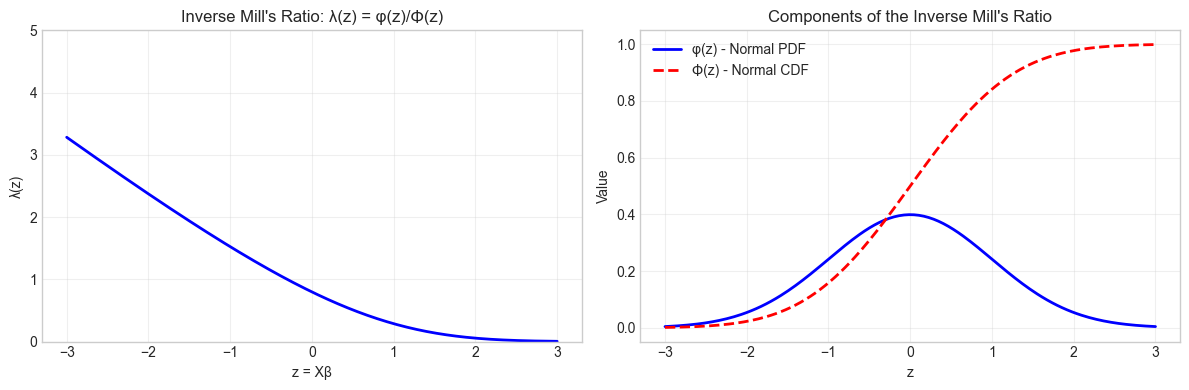

In [50]:
# Visualize the Inverse Mill's Ratio
z = np.linspace(-3, 3, 200)
phi_z = stats.norm.pdf(z)
Phi_z = stats.norm.cdf(z)
lambda_z = phi_z / Phi_z

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Inverse Mill's Ratio
axes[0].plot(z, lambda_z, "b-", linewidth=2)
axes[0].set_xlabel("z = Xβ")
axes[0].set_ylabel("λ(z)")
axes[0].set_title("Inverse Mill's Ratio: λ(z) = φ(z)/Φ(z)")
axes[0].set_ylim([0, 5])
axes[0].grid(True, alpha=0.3)

# Components
axes[1].plot(z, phi_z, "b-", linewidth=2, label="φ(z) - Normal PDF")
axes[1].plot(z, Phi_z, "r--", linewidth=2, label="Φ(z) - Normal CDF")
axes[1].set_xlabel("z")
axes[1].set_ylabel("Value")
axes[1].set_title("Components of the Inverse Mill's Ratio")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.1 Generate Sample Selection Data

In [51]:
# Generate data with sample selection
np.random.seed(42)
n = 2000

# Exogenous variables
age = np.random.uniform(25, 60, n)
education = np.random.uniform(8, 20, n)
married = np.random.binomial(1, 0.6, n)
num_children = np.random.poisson(1.5, n)

# True parameters for selection equation (labor force participation)
gamma_0 = -2.0
gamma_edu = 0.15
gamma_married = 0.3
gamma_children = -0.4  # Exclusion restriction - affects participation but not wages

# True parameters for outcome equation (wages)
beta_0 = 1.0
beta_edu = 0.08
beta_exp = 0.03  # Age as proxy for experience

# Error correlation (the selection effect!)
rho = 0.5
sigma_2 = 1.0

# Generate correlated errors
cov_matrix = [[1, rho * sigma_2], [rho * sigma_2, sigma_2**2]]
errors = np.random.multivariate_normal([0, 0], cov_matrix, n)
u1 = errors[:, 0]  # Selection error
u2 = errors[:, 1]  # Outcome error

# Selection equation
y1_star = (
    gamma_0
    + gamma_edu * education
    + gamma_married * married
    + gamma_children * num_children
    + u1
)
participate = (y1_star > 0).astype(int)

# Outcome equation (log wages, observed only if participate=1)
log_wage_star = beta_0 + beta_edu * education + beta_exp * (age - 25) + u2
log_wage = np.where(participate == 1, log_wage_star, np.nan)

# Create DataFrame
df_heck = pd.DataFrame(
    {
        "participate": participate,
        "log_wage": log_wage,
        "education": education,
        "age": age,
        "married": married,
        "num_children": num_children,
    }
)

print("=== Sample Selection Dataset ===")
print(f"Total observations: {n}")
print(f"Participants (wage observed): {participate.sum()} ({participate.mean():.1%})")
print(
    f"Non-participants (wage missing): {(1 - participate).sum()} ({(1 - participate).mean():.1%})"
)
print(f"\nTrue correlation (ρ): {rho}")

=== Sample Selection Dataset ===
Total observations: 2000
Participants (wage observed): 812 (40.6%)
Non-participants (wage missing): 1188 (59.4%)

True correlation (ρ): 0.5


### 3.2 Naive OLS (Ignoring Selection)

In [52]:
# Naive OLS on observed wages only
df_observed = df_heck[df_heck["participate"] == 1].copy()

X_naive = sm.add_constant(df_observed[["education", "age"]])
y_naive = df_observed["log_wage"]

naive_ols = sm.OLS(y_naive, X_naive).fit()

print("=== Naive OLS (Ignoring Selection Bias) ===")
print(naive_ols.summary().tables[1])

print("\n=== Comparison with True Values ===")
print(f"{'Parameter':<12} {'True':>10} {'Naive OLS':>12} {'Bias':>10}")
print("-" * 46)
print(
    f"{'Intercept':<12} {beta_0:>10.4f} {naive_ols.params['const']:>12.4f} {naive_ols.params['const'] - beta_0:>10.4f}"
)
print(
    f"{'Education':<12} {beta_edu:>10.4f} {naive_ols.params['education']:>12.4f} {naive_ols.params['education'] - beta_edu:>10.4f}"
)
print(
    f"{'Age':<12} {beta_exp:>10.4f} {naive_ols.params['age']:>12.4f} {naive_ols.params['age'] - beta_exp:>10.4f}"
)

=== Naive OLS (Ignoring Selection Bias) ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3309      0.203      6.554      0.000       0.932       1.729
education      0.0414      0.010      4.125      0.000       0.022       0.061
age            0.0274      0.003      8.774      0.000       0.021       0.034

=== Comparison with True Values ===
Parameter          True    Naive OLS       Bias
----------------------------------------------
Intercept        1.0000       1.3309     0.3309
Education        0.0800       0.0414    -0.0386
Age              0.0300       0.0274    -0.0026


### 3.3 Heckman Two-Step Estimator

In [53]:
# Step 1: Probit regression for selection equation
X_selection = sm.add_constant(df_heck[["education", "married", "num_children"]])
y_selection = df_heck["participate"]

probit_selection = Probit(y_selection, X_selection).fit()
print("=== Step 1: Probit Selection Equation ===")
print(probit_selection.summary().tables[1])

Optimization terminated successfully.
         Current function value: 0.573744
         Iterations 5
=== Step 1: Probit Selection Equation ===
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.8899      0.140    -13.514      0.000      -2.164      -1.616
education        0.1395      0.009     15.301      0.000       0.122       0.157
married          0.2860      0.063      4.561      0.000       0.163       0.409
num_children    -0.3574      0.029    -12.454      0.000      -0.414      -0.301


In [54]:
# Step 2: Calculate Inverse Mill's Ratio
linear_pred_selection = probit_selection.predict(X_selection, linear=True)

# λ(z) = φ(z) / Φ(z)
phi = stats.norm.pdf(linear_pred_selection)
Phi = stats.norm.cdf(linear_pred_selection)
inv_mills_ratio = phi / Phi

df_heck["inv_mills"] = inv_mills_ratio

print("=== Inverse Mill's Ratio (first 10 observations) ===")
print(df_heck[["participate", "inv_mills"]].head(10))

=== Inverse Mill's Ratio (first 10 observations) ===
   participate  inv_mills
0            1   1.073553
1            0   1.585293
2            0   0.779353
3            0   1.088165
4            1   1.906179
5            1   0.547552
6            0   1.104148
7            1   0.969816
8            1   1.263197
9            0   1.058680


In [55]:
# Step 3: OLS on outcome equation with IMR
df_observed = df_heck[df_heck["participate"] == 1].copy()

X_outcome = sm.add_constant(df_observed[["education", "age", "inv_mills"]])
y_outcome = df_observed["log_wage"]

heckman_step2 = sm.OLS(y_outcome, X_outcome).fit()

print("=== Step 2: OLS Outcome Equation with Inverse Mill's Ratio ===")
print(heckman_step2.summary().tables[1])

=== Step 2: OLS Outcome Equation with Inverse Mill's Ratio ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2008      0.343      0.586      0.558      -0.472       0.874
education      0.0873      0.015      5.809      0.000       0.058       0.117
age            0.0270      0.003      8.731      0.000       0.021       0.033
inv_mills      0.5520      0.136      4.073      0.000       0.286       0.818


In [56]:
# Interpret results
lambda_coef = heckman_step2.params["inv_mills"]
lambda_pval = heckman_step2.pvalues["inv_mills"]

print("\n=== Heckman Two-Step Results ===")
print(f"\nCoefficient on Inverse Mill's Ratio (λ): {lambda_coef:.4f}")
print(f"P-value: {lambda_pval:.4f}")

if lambda_pval < 0.05:
    print("\n→ The coefficient is SIGNIFICANT")
    print("  This indicates sample selection bias exists.")
    print(
        f"  The sign of ρ (correlation) is {'positive' if lambda_coef > 0 else 'negative'}."
    )
    print(f"\n  Since λ coefficient ≈ σ₁₂ = ρ × σ₂:")
    print(f"  Estimated ρ × σ₂ = {lambda_coef:.4f}")
else:
    print("\n→ The coefficient is NOT significant")
    print("  Selection bias may not be a concern; OLS on observed data could be valid.")

print("\n=== Comparison of Estimates ===")
print(f"{'Parameter':<12} {'True':>10} {'Naive OLS':>12} {'Heckman':>12}")
print("-" * 48)
print(
    f"{'Intercept':<12} {beta_0:>10.4f} {naive_ols.params['const']:>12.4f} {heckman_step2.params['const']:>12.4f}"
)
print(
    f"{'Education':<12} {beta_edu:>10.4f} {naive_ols.params['education']:>12.4f} {heckman_step2.params['education']:>12.4f}"
)
print(
    f"{'Age':<12} {beta_exp:>10.4f} {naive_ols.params['age']:>12.4f} {heckman_step2.params['age']:>12.4f}"
)


=== Heckman Two-Step Results ===

Coefficient on Inverse Mill's Ratio (λ): 0.5520
P-value: 0.0001

→ The coefficient is SIGNIFICANT
  This indicates sample selection bias exists.
  The sign of ρ (correlation) is positive.

  Since λ coefficient ≈ σ₁₂ = ρ × σ₂:
  Estimated ρ × σ₂ = 0.5520

=== Comparison of Estimates ===
Parameter          True    Naive OLS      Heckman
------------------------------------------------
Intercept        1.0000       1.3309       0.2008
Education        0.0800       0.0414       0.0873
Age              0.0300       0.0274       0.0270


### 3.4 Using statsmodels Heckman Function

In [57]:
# Using statsmodels Heckman implementation
from statsmodels.regression.linear_model import OLS

try:
    from statsmodels.discrete.discrete_model import Heckman

    print("Using statsmodels Heckman")
except ImportError:
    print("Heckman not available in this statsmodels version.")
    print("We'll use the two-step implementation above.")

Heckman not available in this statsmodels version.
We'll use the two-step implementation above.


In [58]:
# Alternative: Full implementation using formula API
# This creates a more complete Heckman model


def heckman_two_step(df, outcome_formula, selection_formula, outcome_var):
    """
    Implement Heckman two-step estimator.

    Parameters:
    -----------
    df : DataFrame with all variables
    outcome_formula : list of variable names for outcome equation
    selection_formula : list of variable names for selection equation
    outcome_var : name of outcome variable

    Returns:
    --------
    Dictionary with results
    """
    # Step 1: Probit selection
    selection_df = df.copy()
    X_sel = sm.add_constant(selection_df[selection_formula])
    y_sel = (selection_df[outcome_var].notna()).astype(int)

    probit_model = Probit(y_sel, X_sel).fit(disp=0)

    # Calculate IMR
    xb = probit_model.predict(X_sel, linear=True)
    imr = stats.norm.pdf(xb) / stats.norm.cdf(xb)

    # Step 2: OLS with IMR
    observed_df = df[df[outcome_var].notna()].copy()
    observed_df["imr"] = imr[df[outcome_var].notna()]

    X_out = sm.add_constant(observed_df[outcome_formula + ["imr"]])
    y_out = observed_df[outcome_var]

    ols_model = OLS(y_out, X_out).fit()

    # Compute corrected standard errors (Heckman correction)
    # Note: This is a simplified version

    return {
        "selection": probit_model,
        "outcome": ols_model,
        "rho_sigma": ols_model.params["imr"],
        "rho_sigma_se": ols_model.bse["imr"],
        "rho_sigma_pval": ols_model.pvalues["imr"],
    }


# Run the model
results = heckman_two_step(
    df_heck,
    outcome_formula=["education", "age"],
    selection_formula=["education", "married", "num_children"],
    outcome_var="log_wage",
)

print("=== Heckman Two-Step Complete Results ===")
print("\nSelection Equation (Probit):")
print(results["selection"].summary().tables[1])
print("\nOutcome Equation (with IMR):")
print(results["outcome"].summary().tables[1])

=== Heckman Two-Step Complete Results ===

Selection Equation (Probit):
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.8899      0.140    -13.514      0.000      -2.164      -1.616
education        0.1395      0.009     15.301      0.000       0.122       0.157
married          0.2860      0.063      4.561      0.000       0.163       0.409
num_children    -0.3574      0.029    -12.454      0.000      -0.414      -0.301

Outcome Equation (with IMR):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2008      0.343      0.586      0.558      -0.472       0.874
education      0.0873      0.015      5.809      0.000       0.058       0.117
age            0.0270      0.003      8.731      0.000       0.021       0.033
imr            0.

### 3.5 The Two-Part Model (Alternative)

In [59]:
# Two-Part Model: No correlation correction
# Useful when selection is on observables or when IMR causes multicollinearity

print("=== Two-Part Model ===")
print("\nPart 1: Participation Probability (Probit/Logit)")

# Part 1: Probability of participation
X_part1 = sm.add_constant(df_heck[["education", "married", "num_children"]])
y_part1 = df_heck["participate"]

part1_model = Logit(y_part1, X_part1).fit(disp=0)
print(part1_model.summary().tables[1])

print("\nPart 2: Conditional Outcome (OLS on observed)")

# Part 2: Outcome conditional on participation
df_part2 = df_heck[df_heck["participate"] == 1]
X_part2 = sm.add_constant(df_part2[["education", "age"]])
y_part2 = df_part2["log_wage"]

part2_model = sm.OLS(y_part2, X_part2).fit()
print(part2_model.summary().tables[1])

=== Two-Part Model ===

Part 1: Participation Probability (Probit/Logit)
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.1330      0.238    -13.153      0.000      -3.600      -2.666
education        0.2317      0.016     14.816      0.000       0.201       0.262
married          0.4726      0.105      4.507      0.000       0.267       0.678
num_children    -0.5991      0.050    -12.084      0.000      -0.696      -0.502

Part 2: Conditional Outcome (OLS on observed)
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3309      0.203      6.554      0.000       0.932       1.729
education      0.0414      0.010      4.125      0.000       0.022       0.061
age            0.0274      0.003      8.774      0.000       0.021       0.034

In [60]:
# Prediction with Two-Part Model
def two_part_prediction(df, part1_model, part2_model, part1_vars, part2_vars):
    """
    Make predictions using two-part model.
    E[y] = P(participate) × E[y | participate]
    """
    X1 = sm.add_constant(df[part1_vars])
    X2 = sm.add_constant(df[part2_vars])

    prob_participate = part1_model.predict(X1)
    conditional_outcome = part2_model.predict(X2)

    # Expected outcome (unconditional)
    expected_outcome = prob_participate * conditional_outcome

    return {
        "prob_participate": prob_participate,
        "conditional_outcome": conditional_outcome,
        "expected_outcome": expected_outcome,
    }


predictions = two_part_prediction(
    df_heck,
    part1_model,
    part2_model,
    ["education", "married", "num_children"],
    ["education", "age"],
)

print("=== Two-Part Model Predictions (Sample) ===")
pred_df = pd.DataFrame(
    {
        "P(participate)": predictions["prob_participate"],
        "E[log_wage | part]": predictions["conditional_outcome"],
        "E[log_wage]": predictions["expected_outcome"],
    }
)
print(pred_df.head(10).round(4))

=== Two-Part Model Predictions (Sample) ===
   P(participate)  E[log_wage | part]  E[log_wage]
0          0.3367              2.8362       0.9548
1          0.1430              3.3815       0.4834
2          0.5106              3.4990       1.7864
3          0.3292              3.0451       1.0023
4          0.0796              2.6317       0.2096
5          0.6694              2.8736       1.9237
6          0.3198              2.6260       0.8399
7          0.3907              3.5634       1.3921
8          0.2502              2.9560       0.7396
9          0.3431              3.2682       1.1215


### 3.6 Identification: Exclusion Restriction

In [61]:
# Demonstrate the importance of exclusion restriction
print("=== Identification Considerations ===")
print("\nThe Heckman model requires at least one 'exclusion restriction':")
print("A variable that affects selection but NOT the outcome.")
print("\nIn our example:")
print("• 'num_children' affects labor force participation")
print("• But does not directly affect wages (conditional on participation)")
print("\nThis exclusion restriction helps identify the selection effect.")
print(
    "\nWithout it, the model relies solely on functional form (non-linearity of IMR),"
)
print("which can lead to unstable estimates.")

=== Identification Considerations ===

The Heckman model requires at least one 'exclusion restriction':
A variable that affects selection but NOT the outcome.

In our example:
• 'num_children' affects labor force participation
• But does not directly affect wages (conditional on participation)

This exclusion restriction helps identify the selection effect.

Without it, the model relies solely on functional form (non-linearity of IMR),
which can lead to unstable estimates.


In [ ]:
# Check multicollinearity between IMR and regressors
df_observed = df_heck[df_heck["participate"] == 1].copy()

# Correlation matrix
corr_vars = df_observed[["education", "age", "inv_mills"]].corr()

print("=== Correlation Matrix (Observed Sample) ===")
print(corr_vars.round(4))

print("\nNote: High correlation between IMR and regressors can cause")
print("near-multicollinearity and unstable estimates.")
print("This is why exclusion restrictions are important!")

=== Correlation Matrix (Observed Sample) ===
           education     age  inv_mills
education     1.0000  0.0275    -0.7498
age           0.0275  1.0000    -0.0006
inv_mills    -0.7498 -0.0006     1.0000

Note: High correlation between IMR and regressors can cause
near-multicollinearity and unstable estimates.
This is why exclusion restrictions are important!


---

# ❓ FAQ and Common Pitfalls

---

## Common Mistakes Students Make

### 1. **Using OLS for Binary Outcomes** ❌
**Problem**: "I'll just use OLS with 0/1 as my y variable"  
**Why it's wrong**: Predictions outside [0,1], heteroskedasticity, biased standard errors  
**Solution**: Use Probit or Logit models

### 2. **Interpreting Probit/Logit Coefficients as Marginal Effects** ❌
**Problem**: "Education coefficient is 0.15, so one more year increases employment by 15%"  
**Why it's wrong**: Coefficients are on the LATENT scale, not the probability scale  
**Solution**: Calculate marginal effects: `model.get_margeff()`

### 3. **Forgetting the Exclusion Restriction in Heckman** ❌
**Problem**: Using the exact same variables in selection and outcome equations  
**Why it's wrong**: Identification relies only on functional form (IMR nonlinearity) - unstable!  
**Solution**: Include at least one variable that affects selection but not outcome

### 4. **Comparing Probit and Logit Coefficients Directly** ❌
**Problem**: "Logit coefficients are bigger, so Logit is better"  
**Why it's wrong**: Different scaling! Logit variance ≈ 1.81 × Probit variance  
**Solution**: Compare marginal effects or predictions, not raw coefficients

### 5. **Ignoring Model Diagnostics** ❌
**Problem**: Not checking if the model actually fits well  
**Why it's wrong**: A poorly fitting model gives meaningless predictions  
**Solution**: Check Pseudo R², ROC curves, confusion matrices, residual plots

---

## Frequently Asked Questions

### Q1: When should I use Probit vs. Logit?

**A**: In practice, they give almost identical results. Choose based on:
- **Logit**: Easier interpretation (odds ratios), closed-form CDF
- **Probit**: Natural if you think errors are normal, easier for multivariate extensions
- **Rule of thumb**: Use whichever your field conventionally uses (Economics often prefers Probit)

### Q2: What's a "good" Pseudo R²?

**A**: Pseudo R² values are typically MUCH LOWER than OLS R². 
- 0.2-0.4 is considered excellent
- 0.1-0.2 is good
- < 0.1 can still be useful if predictors are significant
- Focus more on AIC/BIC and predictive accuracy

### Q3: Why is my Heckman IMR coefficient not significant?

**A**: Three possibilities:
1. ✅ **Good news**: There's actually no selection bias! Use regular OLS.
2. ⚠️ **Collinearity**: IMR highly correlated with regressors (check correlations)
3. ⚠️ **Weak exclusion restriction**: Variable doesn't strongly predict selection

### Q4: Can I use Heckman for panel data?

**A**: Yes, but you need extensions:
- Random effects Heckman
- Fixed effects approaches
- Or use specialized packages (e.g., `linearmodels` in Python)

### Q5: What if my outcome is not continuous (for Heckman)?

**A**: Heckman assumes continuous outcome. For other cases:
- Binary outcome → Use bivariate probit
- Count outcome → Use two-part hurdle model
- Ordinal outcome → Use ordered probit with sample selection

### Q6: How do I choose the cutoff threshold for binary classification?

**A**: Depends on your cost function:
- **Medical diagnosis**: Low threshold (maximize sensitivity)
- **Spam detection**: High threshold (maximize specificity)
- **Balanced**: Use Youden's Index from ROC curve: $J = \max(Sensitivity + Specificity - 1)$

### Q7: Why learn MLE if statsmodels does it for me?

**A**: Understanding the mechanics helps you:
- Debug when things go wrong
- Extend to custom models not in packages
- Understand limitations and assumptions
- Interpret error messages

---

## ⚠️ Warning Signs Your Model Has Problems

| Symptom | Possible Issue | Solution |
|---------|----------------|----------|
| Very large coefficients (> 10) | Perfect separation or multicollinearity | Check for perfectly predictive variables; check VIF |
| Optimization doesn't converge | Bad starting values or identification issues | Try different initial values; check for perfect collinearity |
| All predictions near 0.5 | Model has no predictive power | Add relevant variables; check if outcome has enough variation |
| IMR has correlation > 0.9 with X | Multicollinearity in Heckman | Need stronger exclusion restriction |
| Pseudo R² = 0.99 | Overfitting or data leakage | Check for target leakage; validate on test set |

---

---

## 📝 Practice Exercise: Part 3

### Exercise 3.1: Understanding Selection Bias

**Question 1**: Why is the naive OLS estimate biased in the wage example?

<details>
<summary>Click for answer</summary>
Because people who participate in the labor market are not a random sample - they're selected based on factors (like having children) that correlate with wages. This creates omitted variable bias.
</details>

**Question 2**: What does a significant IMR coefficient tell us?

<details>
<summary>Click for answer</summary>
It tells us that selection bias exists - the unobserved factors affecting participation (u₁) are correlated with factors affecting wages (u₂). The sign indicates the direction of bias.
</details>

**Question 3**: Why is "num_children" a good exclusion restriction in our example?

<details>
<summary>Click for answer</summary>
Because having children affects the DECISION to work (childcare responsibilities) but doesn't directly affect WAGE RATE conditional on working (employers don't pay based on number of children).
</details>

---

### Exercise 3.2: Hands-On Challenge

1. **Test sensitivity to correlation**: Change `rho` from 0.5 to 0.0 and re-run. What happens to the IMR coefficient?

2. **Remove exclusion restriction**: Estimate Heckman WITHOUT num_children in selection equation. Compare standard errors.

3. **Compare predictions**: For a specific individual, calculate:
   - Naive OLS prediction
   - Heckman prediction
   - Two-part model prediction
   
4. **Simulate different scenarios**: What if selection makes high-wage workers LESS likely to participate (negative ρ)?

---

---

## Summary

### Key Takeaways

**1. Maximum Likelihood**
- General estimation framework that maximizes the probability of observed data
- Consistent, asymptotically normal, and efficient
- Can be biased in small samples (e.g., σ̂_ML < σ̂_OLS)

**2. Binary Choice Models**
- Use Probit or Logit when outcome is binary (0/1)
- OLS is inappropriate (predictions outside [0,1], heteroskedasticity)
- Interpret via marginal effects (change in probability) or odds ratios (Logit)
- β_logit ≈ 1.8 × β_probit due to different scaling

**3. Sample Selection Models**
- Use when outcome is observed only for a selected subset
- Heckman two-step: Probit → IMR → OLS with IMR
- Significant IMR coefficient indicates selection bias
- Exclusion restriction improves identification
- Two-part model as alternative (ignores selection on unobservables)

In [63]:
# Final summary comparison
print("=" * 60)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 60)

print("\n--- Binary Choice (Employment Example) ---")
print(f"{'Model':<10} {'Pseudo R²':>12} {'AIC':>12}")
print("-" * 36)
print(f"{'Probit':<10} {probit_model.prsquared:>12.4f} {probit_model.aic:>12.1f}")
print(f"{'Logit':<10} {logit_model.prsquared:>12.4f} {logit_model.aic:>12.1f}")

print("\n--- Sample Selection (Wage Example) ---")
print(f"{'Model':<15} {'Education β':>12} {'Age β':>12}")
print("-" * 41)
print(f"{'True':<15} {beta_edu:>12.4f} {beta_exp:>12.4f}")
print(
    f"{'Naive OLS':<15} {naive_ols.params['education']:>12.4f} {naive_ols.params['age']:>12.4f}"
)
print(
    f"{'Heckman':<15} {heckman_step2.params['education']:>12.4f} {heckman_step2.params['age']:>12.4f}"
)
print(
    f"{'Two-Part':<15} {part2_model.params['education']:>12.4f} {part2_model.params['age']:>12.4f}"
)

print("\n" + "=" * 60)

FINAL MODEL COMPARISON SUMMARY

--- Binary Choice (Employment Example) ---
Model         Pseudo R²          AIC
------------------------------------
Probit           0.0884       1146.8
Logit            0.0881       1147.1

--- Sample Selection (Wage Example) ---
Model            Education β        Age β
-----------------------------------------
True                  0.0800       0.0300
Naive OLS             0.0414       0.0274
Heckman               0.0873       0.0270
Two-Part              0.0414       0.0274

